In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math
from scipy.optimize import curve_fit


top_level=f'{os.getcwd()}/../../../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras

%run ../../ASIC_V4/supportFunctions.ipynb

In [2]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False,
    dev         = '/dev/datadev_0',
    asicVersion = 4
)
root.start()

Simulation mode : False
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 20:19:30
GitHash      = 0x563a68027652195474e6a610098a11775111615a
XilinxDnaId  = 0x40020001013a928124b102c5
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.2
BuildServer  = rdsrv408 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 02 Nov 2023 02:16:58 PM PDT
Builder      = ddoering
###################################################


# Baseline TEST all - 320MHz refGenB,RefGenC modified

In [4]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

Camera  ePixHr10kTBatcher  selected.


In [80]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
initSequence = 5
root.EpixHR.InitASIC([initSequence,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_RegisterControl_R0Width12us_AcqWidth24us_320MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 3
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_2.yml
Command executed :  <class 'pyrogue._Command.BaseC

In [6]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(10)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)


In [7]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)



Locked lanes: 3f000


In [8]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

# Set references 
Preamp = 4 #4
Vld1_b = 1 #1
Pixel_CB= 4 #4
Filter_DAC= 38 #33
VRef_DAC = 53 #22

setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

######################################################################################################################
# Remove previous dataset
filename = (f'/u1/lorenzor/10kthr_data/temp.dat')

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53


# Pixel baseline

In [82]:
# print(ASIC.RefGenB.get(), ASIC.RefGenC.get(), ASIC.S2D_1_b.get(), ASIC.shvc_DAC.get(), ASIC.S2dDacBias.get(), ASIC.DHg.get())

# Defaults
ASIC.RefGenB.set(3) #2 bits
ASIC.RefGenC.set(2) #2 bits
ASIC.S2D_1_b.set(0) #3 bits
ASIC.shvc_DAC.set(23) #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(True)


# Take data
dataDef = run_asic_test(numFrames = 2048, initialDelay = 0)[:,:,0:192]



/u1/lorenzor/10kthr_data/temp.dat
Aquisition Counter 324727
DAQ Counter 324641
Number of frames received: 0
Number of frames received: 2001
Delta Aquisition Counter: 4004
Number of frames received: 4004
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


In [83]:
# Test
ASIC.RefGenB.set(3) #2 bits
ASIC.RefGenC.set(0) #2 bits
ASIC.S2D_1_b.set(0) #3 bits
ASIC.shvc_DAC.set(30) #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(False)

# Take data
dataOpt = run_asic_test(numFrames = 2048, initialDelay = 0)[:,:,0:192]


/u1/lorenzor/10kthr_data/temp.dat
Aquisition Counter 328731
DAQ Counter 328645
Number of frames received: 0
Number of frames received: 2000
Delta Aquisition Counter: 4003
Number of frames received: 4003
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


In [86]:
# Dark data
darkDef = np.median(dataDef, axis=0)
darkOpt = np.median(dataOpt, axis=0)

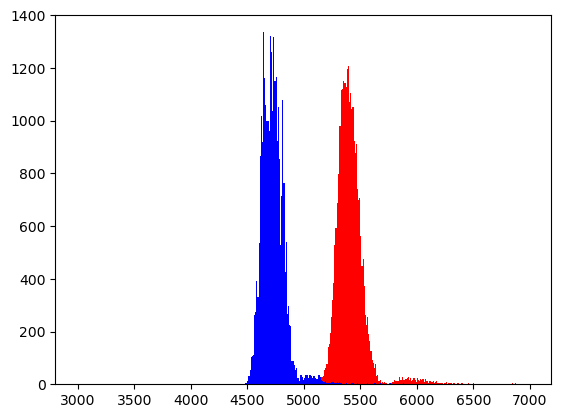

In [95]:
binwidth = 10;
bins     = np.arange(3000, 7000, binwidth);
plt.hist(darkDef.flatten(), bins=bins, color='red',  label = 'Def');
plt.hist(darkOpt.flatten(), bins=bins, color='blue', label = 'Opt');

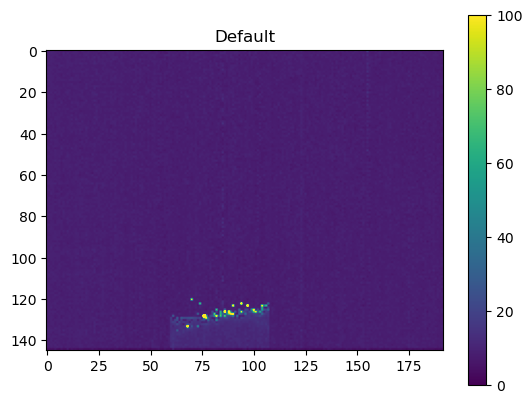

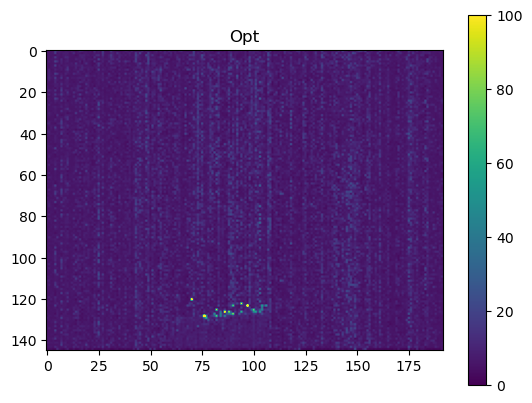

In [98]:
# Noise data
noiseDef = np.std(dataDef, axis=0)
noiseOpt = np.std(dataOpt, axis=0)

plt.imshow(noiseDef, vmin=0, vmax=100)
plt.colorbar()
plt.title('Default')
plt.show()

plt.imshow(noiseOpt, vmin=0, vmax=100)
plt.colorbar()
plt.title('Opt')
plt.show()

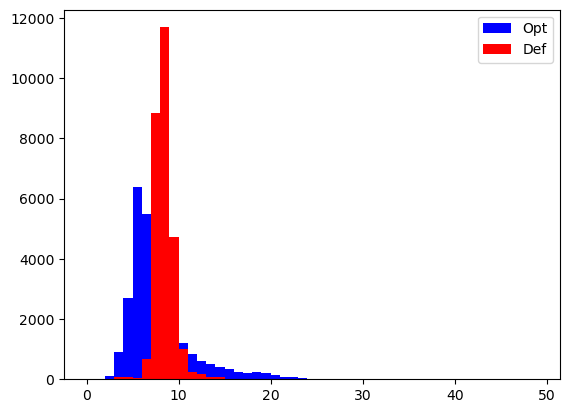

In [102]:
bins     = np.arange(0, 50, 1);
plt.hist(noiseOpt.flatten(), bins=bins, color='blue',  label = 'Opt');
plt.hist(noiseDef.flatten(), bins=bins, color='red',  label = 'Def');
plt.legend()